VQA paddle example

--Rx(3.793)----Rz(6.262)--------*--------Rx(2.035)----Rz(1.282)----*--
                                |                                  |  
--Rx(1.754)----Rz(4.740)--------x--------Rx(5.491)----Rz(3.424)----x--
                                                                      
--Rx(2.634)----Rz(1.480)----Rx(5.253)----Rz(3.794)--------------------
                                                                      
iter: 0   loss: -0.1125


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:


iter: 10   loss: -0.9600
iter: 20   loss: -0.9907
iter: 30   loss: -0.9955
iter: 40   loss: -0.9982
iter: 50   loss: -0.9987
iter: 60   loss: -0.9994
iter: 70   loss: -0.9998
iter: 80   loss: -1.0000
iter: 90   loss: -1.0000
iter: 100   loss: -1.0000
iter: 110   loss: -1.0000
The minimum of the loss function: -0.9999978
Parameters after optimizationL theta:
 [3.1430261e+00 9.6836902e-04 5.1940188e+00 4.3638558e+00 7.3632236e+00
 2.8058007e+00 3.1410060e+00 6.2810960e+00 6.7863107e+00 2.5642626e+00
 4.3773508e+00 1.8674097e+00]
--Rx(3.143)----Rz(4.364)--------*--------Rx(3.141)----Rz(2.564)----*--
                                |                                  |  
--Rx(0.001)----Rz(7.363)--------x--------Rx(6.281)----Rz(4.377)----x--
                                                                      
--Rx(5.194)----Rz(2.806)----Rx(6.786)----Rz(1.867)--------------------
                                                                      
state_final:
 [ 6.4729538e-04+8.1474544e-

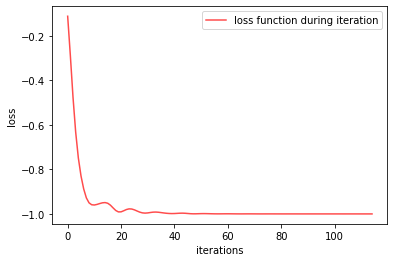

In [1]:
# 加入需要用到的包
import matplotlib.pyplot as plt
import numpy as np
import paddle
import paddle_quantum
from paddle_quantum import Hamiltonian

def create_circuit(num_qubits, depth):
    # 步骤1.1：构建 N 量子比特线路
    circuit = paddle_quantum.ansatz.Circuit(num_qubits)
    # 步骤1.2：对每一层添加量子门
    for _ in range(0, depth):
        circuit.rx('full')
        circuit.rz('full')
        circuit.cnot('linear')
    return circuit

num_qubits = 3
depth = 2
cir = create_circuit(num_qubits, depth)
print(cir)

psi_target = np.kron(
    np.kron(np.array([1, 0]), np.array([0, 1])),
    np.array([1/np.sqrt(2), 1/np.sqrt(2)])
)  # <01+|
psi_target = paddle_quantum.state.to_state(paddle.to_tensor(psi_target), dtype=paddle_quantum.get_dtype())
fid_func = paddle_quantum.loss.StateFidelity(psi_target)

# 首先，我们给出一些训练用参数
ITR = 115      # 学习迭代次数
LR = 0.2       # 学习速率

# 记录迭代中间过程:
loss_list = []
parameter_list = []
# 选择优化器，通常选用Adam
opt = paddle.optimizer.Adam(learning_rate = LR, parameters = cir.parameters())
# 迭代优化
for itr in range(ITR):
    state = cir()
    # 计算损失函数
    loss = -fid_func(state)
    # 通过梯度下降算法优化
    loss.backward()
    opt.minimize(loss)
    opt.clear_grad()
    # 记录学习曲线
    loss_list.append(loss.numpy()[0])
    parameter_list.append(cir.param.numpy())
    if itr % 10 == 0:
        print('iter:', itr, '  loss: %.4f' % loss.numpy())

# 输出最终损失函数值
print('The minimum of the loss function:', loss_list[-1])
# 输出最终量子电路参数
theta_final = parameter_list[-1]
print("Parameters after optimizationL theta:\n", theta_final)
# 绘制最终电路与输出量子态
# 输入量子电路参数需要转化为paddle.tensor类型
theta_final = paddle.to_tensor(theta_final)
# 绘制电路
print(cir)

# 最终得到量子态
state_final = cir()
print("state_final:\n", state_final)

# 绘制迭代过程中损失函数变化曲线
plt.figure(1)
ITR_list = []
for i in range(ITR):
    ITR_list.append(i)
func = plt.plot(ITR_list, loss_list, alpha=0.7, marker='', linestyle='-', color='r')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend(labels=["loss function during iteration"], loc='best')
plt.show()

qutrunk & paddle example

In [1]:
import numpy as np
import paddle
from paddle.autograd import PyLayer

from qutrunk.circuit import QCircuit
from qutrunk.circuit.gates import Ry, PauliZ

# calculate circuit gradient
def parameter_shift(circuit_func, circuit, obs, input_data, shift=np.pi/2):
    """ 
    Backward pass computation, calculate the gradient of quantum circuit by parameter shift rule.
    """
    input_list = np.array(input_data.tolist())
    
    shift_right = input_list + np.ones(input_list.shape) * shift
    shift_left = input_list - np.ones(input_list.shape) * shift
    
    gradients = []
    for i in range(len(input_list)):
        expectation_right = circuit_func(circuit, obs, shift_right[i])
        expectation_left  = circuit_func(circuit, obs, shift_left[i])
        
        gradient = np.array([expectation_right]) - np.array([expectation_left])
        gradients.append(gradient)
    gradients = np.squeeze(np.array(gradients).T)
    return gradients

# define circuit layer by PyLayer
class CircuitLayer(PyLayer):
    @staticmethod
    def forward(ctx, circuit, obs, x):
        def circuit_func(circuit, obs, input_data):
            cc = circuit.bind_parameters({"phi": input_data})
            expval = cc.expval_pauli(obs)
            return expval
        expval = circuit_func(circuit, obs, x)
        out = paddle.to_tensor(expval, stop_gradient=False)
        ctx.save_for_backward(circuit, obs, x)
        
        ctx.func = circuit_func
        return out

    @staticmethod
    def backward(ctx, dy):
        circuit, obs, input_data, = ctx.saved_tensor()
        grad = parameter_shift(ctx.func, circuit, obs, input_data)
        grad = paddle.to_tensor(grad, dtype='float32', stop_gradient=False)
        grad = paddle.reshape(grad, dy.shape)
        return grad

phi = paddle.to_tensor(0.12, stop_gradient=False)

# define circuit by qutrunk
def def_circuit():
    circuit = QCircuit()
    q = circuit.allocate(1)
    phi = circuit.create_parameter("phi")
    Ry(phi) * q[0]
    return circuit, PauliZ(q[0])

circuit, obs = def_circuit()

# optimizer 
sgd_optimizer = paddle.optimizer.SGD(learning_rate=0.01, parameters=[phi])

total_epoch = 140
for i in range(total_epoch):
    # apply circuit layer
    z = CircuitLayer.apply(circuit, obs, phi)
    loss = z.mean()
    loss.backward()
    sgd_optimizer.step()
    sgd_optimizer.clear_grad()
    
    if i%20 == 0:
        print("epoch {} loss {}".format(i, loss.numpy()))
        
print("finished training, loss {}".format(loss.numpy()))
# final phi after optimize
print("final_phi:", phi)



epoch 0 loss [0.99280864]
epoch 20 loss [0.9841885]
epoch 40 loss [0.9654116]
epoch 60 loss [0.92516124]
epoch 80 loss [0.8417737]
epoch 100 loss [0.6806265]
epoch 120 loss [0.4073994]
finished training, loss [0.0533426]
final_phi: Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [1.53739989])


VQA: qutrunk & paddle example

iter: 0   loss: -0.4825
iter: 10   loss: -0.7094
iter: 20   loss: -0.8567
iter: 30   loss: -0.9381
iter: 40   loss: -0.9772
iter: 50   loss: -0.9906
iter: 60   loss: -0.9964
iter: 70   loss: -0.9984
iter: 80   loss: -0.9993
iter: 90   loss: -0.9997
iter: 100   loss: -0.9999
iter: 110   loss: -0.9999
The minimum of the loss function: -0.99995613
Parameters after optimizationL theta:
 [Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [3.15539837]), Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [1.50827551]), Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [1.09872043]), Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [3.13573074]), Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [8.55821419]), Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [2.46809983]), Tensor(shape=[1], dtype=float32, place=Place(cpu)

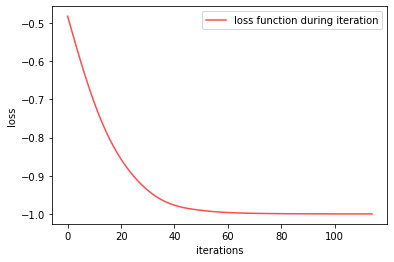

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
import paddle
from paddle.autograd import PyLayer
from typing import Union, Optional

from qutrunk.circuit import QCircuit
from qutrunk.circuit.gates import Rx, Rz, CNOT, PauliZ

# 定义用于训练的含参量子线路
def circuit_ansatz(num_qubits, depth):
    circuit = QCircuit()
    q = circuit.allocate(num_qubits)
    angles = ["theta-" + str(i) for i in range(2 * num_qubits * depth)]
    params = circuit.create_parameters(angles)

    idx = 0
    for i in range(depth):
        for j in range(num_qubits):
            Rx(params[idx]) * q[j]
            idx += 1
        for j in range(num_qubits):
            Rz(params[idx]) * q[j]
            idx += 1
        for j in range(num_qubits - 1):
            CNOT * (q[j], q[j+1])
    
    return circuit, PauliZ(q[0])

# 计算量子线路梯度值
def parameter_shift(circuit, exp_op, input_data, shift=np.pi/2):
    """ 
    Backward pass computation, calculate the gradient of quantum circuit by parameter shift rule.
    """
    input_list = np.array(input_data)
    
    gradients = []
    for i in range(len(input_list)):
        shift_right = np.copy(input_list)
        shift_right[i] += shift
        shift_left = np.copy(input_list)
        shift_left[i] -= shift

        params = {"theta-" + str(i): shift_right[i] for i in range(len(shift_right))}
        cir = circuit.bind_parameters(params)
        expectation_right = cir.expval_pauli(exp_op)

        params = {"theta-" + str(i): shift_left[i] for i in range(len(shift_left))}
        cir = circuit.bind_parameters(params)
        expectation_left = cir.expval_pauli(exp_op)
        
        gradient = np.array([expectation_right]) - np.array([expectation_left])
        gradients.append(gradient)
    gradients = np.squeeze(np.array(gradients).T)
    return gradients

# define circuit layer by PyLayer
class CircuitLayer(PyLayer):
    @staticmethod
    def forward(ctx, circuit, exp_op, x):
        params = {"theta-" + str(i): x[i] for i in range(len(x))}
        cir = circuit.bind_parameters(params)
        expval = cir.expval_pauli(exp_op)
        out = paddle.to_tensor(expval, stop_gradient=False)
        ctx.save_for_backward(circuit, exp_op, x)
        return out

    @staticmethod
    def backward(ctx, dy):
        circuit, exp_op, input_data, = ctx.saved_tensor()
        grad = parameter_shift(circuit, exp_op, input_data)
        gradients = []
        for g in grad:
            gradients.append(paddle.to_tensor(g, dtype='float32', stop_gradient=False))
        return tuple(gradients)


# 首先，我们给出一些训练用参数
ITR = 115      # 学习迭代次数
LR = 0.02       # 学习速率

# 记录迭代中间过程:
loss_list = []
parameter_list = []
# 构造线路
num_qubits = 3
depth = 2

# 量子线路
circuit, op = circuit_ansatz(num_qubits, depth)
# 随机构造参数，并绑定到线路上
angles = [random.random() * 10 for _ in range(len(circuit.get_parameters()))]
# paddle tensor
params = [paddle.to_tensor(angles[i], stop_gradient=False) for i in range(len(angles))]
# 选择优化器，通常选用Adam
opt = paddle.optimizer.Adam(learning_rate = LR, parameters = params)
# 迭代优化
for itr in range(ITR):
    out = CircuitLayer.apply(circuit, op, params)
    # 计算损失函数
    loss = out.mean()
    # 通过梯度下降算法优化
    loss.backward()
    opt.minimize(loss)
    opt.clear_grad()
    # 记录学习曲线
    loss_list.append(loss.numpy()[0])
    if itr % 10 == 0:
        print('iter:', itr, '  loss: %.4f' % loss.numpy())

# 输出最终损失函数值
print('The minimum of the loss function:', loss_list[-1])
# 输出最终量子电路参数
print("Parameters after optimizationL theta:\n", params)
# 输出最终量子态
params = {"theta-" + str(i): params[i] for i in range(len(params))}
cir = circuit.bind_parameters(params)
state = cir.get_statevector()
print("circuit final state:\n", state)
# 绘制电路
circuit.draw()

# 绘制迭代过程中损失函数变化曲线
plt.figure(1)
ITR_list = []
for i in range(ITR):
    ITR_list.append(i)
func = plt.plot(ITR_list, loss_list, alpha=0.7, marker='', linestyle='-', color='r')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend(labels=["loss function during iteration"], loc='best')
plt.show()
